In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import tensorflow as tf
import time
import scipy.misc
import matplotlib as mp
import matplotlib.pyplot as plt
import itertools
import cPickle
import collections
import Image, ImageDraw
import PIL
from PIL import ImageFont
import os
import glob
%matplotlib inline

In [2]:
def cifar10_concatenate():
    
    img = np.zeros([50000,3072])
    lbl = np.zeros([50000])
    for i in range(5):
        with open('/home/skyolia/tensorflow_project/cifar-10/cifar-10-batches-py/data_batch_'+str(i+1),'rb') as f:
            data = cPickle.load(f)
        for j in range(10000):
            img[j+10000*i] = data['data'][j]
            lbl[j+10000*i] = data['labels'][j]
        
        #print(lbl)
        #print("//////////////////////////////////////////////")
        
    return img, lbl

In [3]:
with open('/home/skyolia/tensorflow_project/cifar-10/cifar-10-batches-py/test_batch','rb') as f:
    data2 = cPickle.load(f)
    test_labels = np.asarray(data2['labels'])
    test_data = np.asarray(data2['data'])
    

In [4]:
train_data, train_labels = cifar10_concatenate()
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(50000, 3072)
(50000,)
(10000, 3072)
(10000,)


In [5]:
def cifar10_reshape(data):
    
    size = data.shape[0]
    img = np.zeros([size,3072])
    
    for i in range(size):
        imageToUse = data[i]
        
        image = imageToUse.reshape(3,32,32).transpose(1,2,0)
        elmn = image.flatten()
        
        img[i] = elmn
        
    return img
    

In [6]:
def normalisation(array):
    
    array = array.astype('float32')
    array_nomalized = array / 255.0       
    return array_nomalized
        

In [7]:
def cifar10_preparation():
    
    train_reshape = cifar10_reshape(train_data)
    test_reshape = cifar10_reshape(test_data)
    print("reshape done")
    
    norm_train_data = normalisation(train_reshape)
    norm_test_data = normalisation(test_reshape)
    print("normalisation done")
    
    #flip_train = flip_cifar10(norm_train_data)
    #print("flip done")
    
    #data_train_set = np.concatenate((norm_train_data, flip_train), axis=0)
    #label_train_set = np.concatenate((train_labels, train_labels), axis = 0)
    
    return norm_train_data, norm_test_data
    
    

In [8]:
a,b = cifar10_preparation()
print(a.shape)
print(b.shape)
print(train_labels.shape)
print(test_labels.shape)

reshape done
normalisation done
(50000, 3072)
(10000, 3072)
(50000,)
(10000,)


In [9]:
def create_batches(batch_size, isTrain):
    
    while (True):
        if isTrain:
            for i in xrange(0, len(train_labels), batch_size):
                yield(a[i:i+batch_size],train_labels[i:i+batch_size])
        else:
            for i in xrange(0, len(test_labels), batch_size):
                yield(b[i:i+batch_size],test_labels[i:i+batch_size])     
        

In [10]:
def augmented_params(weights, dim):
    
    keys = weights.keys()
    final = {}
    k = 0
    for i in sorted(keys):
        w = weights[i]
        d = w.get_shape()[dim]
        if dim == 3:
            if i == 'wc8':
                final[k] = w
                k+=1
                continue
            ori = w[:,:,:,1]
        elif dim == 2:
            if i == 0:
                final[k] = w
                k+=1
                continue
            ori = w[:,:,1,:]
        inv = tf.image.flip_up_down(ori)
        ori_inv = tf.stack([inv, ori], dim)
        final[k] = ori_inv
        for j in range(1, d):
            if dim == 3:
                ori = w[:,:,:,j]
            elif dim == 2:
                ori = w[:,:,j,:]
            inv = tf.image.flip_up_down(ori)
            ori_inv = tf.stack([inv, ori], dim)
            final[k] = tf.concat_v2([ori_inv, final[k]], dim)
        
        k+=1
    
    return final

def augmented_bias(biases):
    
    keys = biases.keys()
    final = {}
    k = 0
    for i in keys:
        w = biases[i]
        if i == 'bc8':
            final[k] = w
            k+=1
            continue
            
        b = list()
        d = w.get_shape()[0]
        for i in range(d):
            b.append(w[i])
            b.append(w[i])
            
        arr = tf.convert_to_tensor(b)
        final[k] = arr
        k+=1
    
    return final

In [11]:
def batch_norm(x, n_out, phase_train, convolutional = False, scope='bn'):
    """
    Batch normalization on convolutional maps.
    Args:
        x:           Tensor, 4D BHWD input maps
        n_out:       integer, depth of input maps
        phase_train: boolean tf.Varialbe, true indicates training phase
        scope:       string, variable scope
    Return:
        normed:      batch-normalized maps
    """
    with tf.variable_scope(scope):
        beta = tf.Variable(tf.constant(0.0, shape=[n_out]),
                                     name='beta', trainable=True)
        gamma = tf.Variable(tf.constant(1.0, shape=[n_out]),
                                      name='gamma', trainable=True)
        if convolutional:
            batch_mean, batch_var = tf.nn.moments(x, [0,1,2], name='moments')
        
        else:
            batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
        
        ema = tf.train.ExponentialMovingAverage(decay=0.999)
        
        def mean_var_with_update():
            ema_apply_op = ema.apply([batch_mean, batch_var])
            with tf.control_dependencies([ema_apply_op]):
                return tf.identity(batch_mean), tf.identity(batch_var)

        mean, var = tf.cond(phase_train,
                            mean_var_with_update,
                            lambda: (ema.average(batch_mean), ema.average(batch_var)))
        normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)
    return normed

(3, 3, 3, 96)
(3, 3, 96, 96)
(3, 3, 96, 192)
(3, 3, 192, 192)
(3, 3, 192, 384)
(3, 3, 384, 384)
(1, 1, 384, 384)
(1, 1, 384, 10)
<class 'tensorflow.python.framework.ops.Tensor'>
(384,)
<class 'tensorflow.python.ops.variables.Variable'>
(10,)
(?, 32, 32, 96)
(?, 32, 32, 96)
(?, 16, 16, 96)
(?, 16, 16, 192)
(?, 16, 16, 192)
(?, 8, 8, 192)
(?, 8, 8, 384)
(?, 8, 8, 384)
(?, 4, 4, 384)
(?, 4, 4, 384)
(?, 4, 4, 10)
(?, 1, 1, 10)
(?, 10)
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are creat

KeyboardInterrupt: 

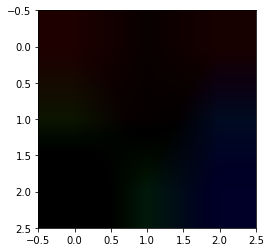

In [12]:
tf.reset_default_graph()
embedding_size = 1024
learning_rate = 1e-3
batch_size = 100
display_step = 1
logs_path = "/home/skyolia/tensorflow_project/cifar-10/CNN/chap3/gap/test_6/"
    
    #mnist = tf.contrib.learn.datasets.mnist.read_data_sets(train_dir=logs_path + 'data', one_hot=True)
    
    # Network Parameters
n_input = 3072  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
strides=1
k=2    
    # tf Graph input
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, n_input], name="x_input")
    y = tf.placeholder(tf.int64, shape=[None], name="y_input")
    prob_1=tf.placeholder(tf.float32)
    prob_2=tf.placeholder(tf.float32)
    phase_train = tf.placeholder(tf.bool)

    
    # Store layers weight & bias
with tf.name_scope("weights"):
        
    weights = {

    'wc1': tf.get_variable(name = "w1",shape = [3, 3, 3, 48], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc2': tf.get_variable(name = "w2",shape = [3, 3, 48, 48], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc3': tf.get_variable(name = "w3",shape = [3, 3, 48, 96], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc4': tf.get_variable(name = "w4",shape = [3, 3, 96, 96], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc5': tf.get_variable(name = "w5",shape = [3, 3, 96, 192], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc6': tf.get_variable(name = "w6",shape = [3, 3, 192, 192], initializer=tf.contrib.layers.xavier_initializer_conv2d()),  
    'wc7': tf.get_variable(name = "w7",shape = [1, 1, 192, 192], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
    'wc8': tf.get_variable(name = "w8",shape = [1, 1, 192, 10], initializer=tf.contrib.layers.xavier_initializer_conv2d()),
}
    
    
with tf.name_scope("biases"):
    
    biases = {
    
    'bc7': tf.Variable(tf.constant(0.1, shape=[192]), name = "b7"),   
    'bc8': tf.Variable(tf.constant(0.1, shape=[10]), name = "b8"),
}

ult_w = augmented_params(weights, 3)
final = augmented_params(ult_w, 2)
for i in range(len(final)):
    
    print(final[i].get_shape())

ult_b = augmented_bias(biases)
for i in range(len(ult_b)):
    
    print(type(ult_b[i]))
    print(ult_b[i].get_shape())
    
x_image = tf.reshape(x,[-1,32,32,3])
x_bn = batch_norm(x_image, 3, phase_train, convolutional = True)

hidden_1 = tf.nn.conv2d(x_bn, final[0], strides=[1, 1, 1, 1], padding='SAME')
hidden_1_bn = batch_norm(hidden_1, 96, phase_train, convolutional = True)
hidden_1_relu = tf.nn.elu(hidden_1_bn)
print(hidden_1_relu.get_shape())

hidden_2 = tf.nn.conv2d(hidden_1_relu, final[1], strides=[1, 1, 1, 1], padding='SAME')
hidden_2_bn = batch_norm(hidden_2, 96, phase_train, convolutional = True)
hidden_2_relu = tf.nn.elu(hidden_2_bn)
print(hidden_2_relu.get_shape())

pool_1 = tf.nn.max_pool(hidden_2_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_1_do=tf.nn.dropout(pool_1, keep_prob=prob_2)
print(pool_1.get_shape())

hidden_3 = tf.nn.conv2d(pool_1_do, final[2], strides=[1, 1, 1, 1], padding='SAME')
hidden_3_bn = batch_norm(hidden_3, 192, phase_train, convolutional = True)
hidden_3_relu = tf.nn.elu(hidden_3_bn)
print(hidden_3_relu.get_shape())

hidden_4 = tf.nn.conv2d(hidden_3_relu, final[3], strides=[1, 1, 1, 1], padding='SAME')
hidden_4_bn = batch_norm(hidden_4, 192, phase_train, convolutional = True)
hidden_4_relu = tf.nn.elu(hidden_4_bn)
print(hidden_4_relu.get_shape())

pool_2 = tf.nn.max_pool(hidden_4_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_2_do=tf.nn.dropout(pool_2, keep_prob=prob_2)
print(pool_2.get_shape())

hidden_5 = tf.nn.conv2d(pool_2_do, final[4], strides=[1, 1, 1, 1], padding='SAME')
hidden_5_bn = batch_norm(hidden_5, 384, phase_train, convolutional = True)
hidden_5_relu = tf.nn.elu(hidden_5_bn)
print(hidden_5_relu.get_shape())

hidden_6 = tf.nn.conv2d(hidden_5_relu, final[5], strides=[1, 1, 1, 1], padding='SAME')
hidden_6_bn = batch_norm(hidden_6, 384, phase_train, convolutional = True)
hidden_6_relu = tf.nn.elu(hidden_6_bn)
print(hidden_6_relu.get_shape())

pool_3 = tf.nn.max_pool(hidden_6_relu, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='VALID')
pool_3_do=tf.nn.dropout(pool_3, keep_prob=prob_1)
print(pool_3.get_shape())

hidden_7 = tf.nn.conv2d(pool_3_do, final[6], strides=[1, 1, 1, 1], padding='VALID') + ult_b[0]
#hidden_7_bn = batch_norm(hidden_7, 384, phase_train, convolutional = True)
hidden_7_relu = tf.nn.elu(hidden_7)
hidden_7_do=tf.nn.dropout(hidden_7_relu, keep_prob=prob_1)
print(hidden_7_relu.get_shape())

hidden_8 = tf.nn.conv2d(hidden_7_do, final[7], strides=[1, 1, 1, 1], padding='VALID') + ult_b[1]
hidden_8_relu = tf.nn.elu(hidden_8)
print(hidden_8_relu.get_shape())

gap = tf.nn.avg_pool(hidden_8_relu, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding="VALID")
print(gap.get_shape())

out_y = tf.reshape(gap, (-1,10))
print(out_y.get_shape())
    
    # Define loss and optimizer
with tf.name_scope('cross_entropy'):
    
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(out_y, y))
        
with tf.name_scope('learning_rate'):
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Evaluate model
with tf.name_scope('Accuracy'):
    
    correct_pred = tf.equal(tf.argmax(out_y, 1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

acc_test_summary = tf.summary.scalar("test_accuracy", accuracy)

lost_training_summary = tf.scalar_summary("training_lost", cost)
lost_test_summary = tf.scalar_summary("test_lost", cost)



#summary_op = tf.merge_all_summaries()    


writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())
saver = tf.train.Saver(max_to_keep=300)

epoch = 0

start = time.time()

test_cumulative_accuracy = 0.0
train_cumulative_accuracy = 0.0

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, {phase_train: True})
    while(True):
            gen_batch = create_batches(125,True)
            test_accuracy = 0.0
            train_accuracy = 0.0
            c = 0.0
            c2 = 0.0
            print("epoch : ", epoch)
            for j in range(400):
                    #print("j = ",j)
                    img, lbl = gen_batch.next()
                    optimizer.run(feed_dict={x: img, y: lbl, prob_1: 0.75, prob_2:0.4, phase_train: True})
                    c += sess.run(cost, feed_dict={x: img, y: lbl, prob_1: 1., prob_2:1., phase_train: False})
                    
                    batch_train_accuracy = sess.run(accuracy, feed_dict={x: img, y: lbl, prob_1: 1., prob_2:1., phase_train: False})
                    
                    train_accuracy += batch_train_accuracy
                    if (j%80 == 0):
                        print("j = ",j)
                        print("batch_train_accuracy = ",batch_train_accuracy)
                        
                    train_lost_summ = sess.run(lost_training_summary, 
                                                               feed_dict={x: img, y: lbl, prob_1: 1., prob_2:1., phase_train: False})
                    writer.add_summary(train_lost_summ,epoch * 400 + j)
                        
                #summary = sess.run(summary_op, feed_dict={x: img, y: lbl})
            
            
            
            #print("train accuracy = ",train_accuracy)
            train_cost = c/400
            print("lost = ", train_cost)
            train_cumulative_accuracy = train_accuracy/400
            
            end = time.time()
            duree = end-start
            print("train_cumulative_accuracy : ", train_cumulative_accuracy)
            print("duree : ", duree)
            
            gen_batch2 = create_batches(100,False)
            for j in range(100):
                img2, lbl2 = gen_batch2.next()
                
                batch_test_accuracy = sess.run(accuracy, feed_dict={x: img2, y: lbl2, prob_1: 1., prob_2:1., phase_train: False})
                c2 += sess.run(cost, feed_dict={x: img2, y: lbl2, prob_1: 1., prob_2:1., phase_train: False})
                    
                test_accuracy += batch_test_accuracy
                test_acc_summ, test_lost_summ = sess.run([acc_test_summary, lost_test_summary], 
                                                         feed_dict={x: img2, y: lbl2, prob_1: 1., prob_2:1., phase_train: False})
            
                writer.add_summary(test_acc_summ,epoch * 100 + j)
                writer.add_summary(test_lost_summ,epoch * 100 + j)
            
            test_cost = c2/100
            print("lost = ", test_cost)
            
            test_cumulative_accuracy = test_accuracy/100
            print("test_cumulative_accuracy : ", test_cumulative_accuracy)
            
            file_name = "./v2"+str(epoch)+"_model.ckpt"
            saver.save(sess, file_name)
            
            epoch += 1 
            
            f1 = final[0]
            f111 = f1[:,:,:,0]
            f11 = sess.run(f111, feed_dict={x: img2, y: lbl2, prob_1: 1., prob_2:1., phase_train: False})
            plt.imshow(f11, interpolation="bilinear", cmap="gray")            
    
print("model saved")


(3, 3, 3, 96)
[[[-0.00418605 -0.11973024 -0.05742687]
  [ 0.06996612 -0.0166792   0.08382815]
  [ 0.05282145  0.07407408  0.10238234]]

 [[-0.09196088  0.02103742  0.01227724]
  [-0.09875865  0.01605891  0.06862664]
  [ 0.07851471 -0.03820511  0.11294366]]

 [[-0.08931942 -0.07630096 -0.07525756]
  [ 0.08001288  0.02109136 -0.06673672]
  [ 0.04442513  0.02749079 -0.10545052]]]


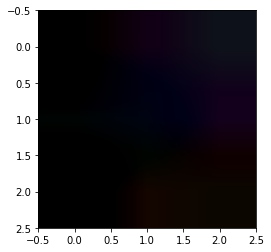

In [13]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init, {phase_train: False})
    saver.restore(sess, "./v20_model.ckpt")


    f1 = final[0]
    print(f1.get_shape())
    f111 = f1[:,:,:,10]
    f222 = f1[:,:,:,78]
    
    f11,f22 = sess.run([f111, f222])
    print(f11)
    plt.imshow(f11, interpolation="bilinear", cmap="gray")
    #plt.imshow(f22, interpolation="bilinear", cmap="gray")

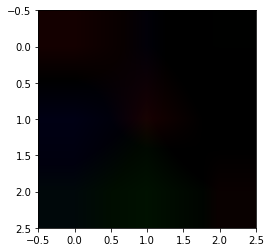

In [15]:
plt.imshow(f11, interpolation="bilinear", cmap="gray")